Overview
========

This notebook was used to implement the algorithms and evaluation described in the paper.

In [3]:
import networkx as nx
import numpy as np
from copy import deepcopy
import random
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 18})

##########################################

def inverse_hcat(graph,degrees):
  #degrees is a dictionary with keys as argument indices and values as degrees
  d=np.zeros(len(degrees))
  for deg in degrees:
    d[deg]=degrees[deg]
  adj=nx.convert_matrix.to_numpy_array(graph)
  adj=adj.T
  M=np.diag(d)
  return d+np.matmul(M,np.matmul(adj,d))

def inverse_card(graph,degrees):
  d=np.zeros(len(degrees))
  for deg in degrees:
    d[deg]=degrees[deg]

  adj=nx.convert_matrix.to_numpy_array(graph)
  adj=adj.T
  att=np.sum(adj,axis=1)
  att_m=np.diag(np.sum(adj,axis=1))
  div=np.zeros(len(d))
  np.divide(np.matmul(np.diag(d),np.matmul(adj,d)),att,where=att!=0,out=div)
  lhs=d+np.matmul(att_m,d)+div
  return lhs

def inverse_mbs(graph,degrees):
  adj=nx.convert_matrix.to_numpy_array(graph)
  adj=adj.T

  d=np.zeros(len(degrees))
  for deg in degrees:
    d[deg]=degrees[deg]
  M=np.diag(d)

  return d+np.matmul(M,np.max(np.matmul(adj,M),axis=1))

##########################################
class CAF:
    def __init__(self,af,intervals):
        self.af = af #this is a networkx graph
        self.intervals = intervals #this is a dictionary of min/max tuples with arguments as keys
    
    def is_rational(self,semantics):
        #semantics is one of hcat, card, mbs
        #a CAF is irrational if there is no weighting s.t. sigma(a_i) \in I(a_i) for all a_i
        #so we need to do the inverse semantics thing and check whether all arguments are in the interval.
        #we can do this by checking whether the minimum of the CAF is valid (assuming axial-radiality)
        #deg = [0] * len(self.af.nodes)
        deg = {}
        for i in range(len(self.af.nodes)):
           deg[i]=min(self.intervals[i])
        weights = semantics(self.af,deg)
        if max(weights)>1 or min(weights)<0:
            return False
        else:
            return True
    
    def is_fully_rational(self,semantics):
       #as above, but check max interval
        deg = [0] * len(self.af.nodes)
        for i in range(len(self.af.nodes)):
           deg[i]=max(self.intervals[i])
        weights = semantics(self.af,deg)
        if max(weights)>1 or min(weights)<0:
            return False
        else:
            return True
      
    def is_epsilon_rational(self,semantics,epsilon):
      for i in range(len(self.af.nodes)):
          if not epsilon <= max(self.intervals[i])-min(self.intervals[i]):
             return False
          new_caf = deepcopy(self)
          new_caf.intervals[i]=(self.intervals[i][1]-epsilon,self.intervals[i][1])
          if not new_caf.is_rational(semantics):
              return False
      return True
    
    def best_refinement(self,semantics,epsilon):
        for a in self.arguments:
            new_caf=deepcopy(self)
            new_caf.intervals[a]=(self.intervals[a][1],self.intervals[a][1])
            if not new_caf.is_rational(semantics):
                l = min(self.intervals[a])
                r = max(self.intervals[a])
                found = False
                while not found:
                   m = (l+r)/2
                   new_caf2 = deepcopy(new_caf)
                   new_caf2.intervals[a]=(m,m)
                   if not new_caf2.is_rational(semantics):
                      r = m
                      if (l-2/2)<epsilon:
                         self.intervals[a]=(min(self.intervals[a]),m)
                         found = True
                   else:
                      l = m

In [17]:
SEMANTICS=inverse_hcat  #the semantics we are testing

In [5]:
NUM_TRIALS = 100

def make_random_graph(size):
    g = nx.fast_gnp_random_graph(size,0.5)
    intervals = {}
    for i in range(size):
        intervals[i]=(0,1)
    return CAF(g,intervals)

for i in range(NUM_TRIALS):
    #generate a random CAF
    caf = make_random_graph(10)
    while not caf.is_rational(SEMANTICS) and caf.is_epsilon_rational(SEMANTICS,0.01):
        caf = make_random_graph(10)
        caf.best_refinement(SEMANTICS,0.01)
        if not caf.is_epsilon_rational(SEMANTICS,0.01):
            print("Error")
            break




The next part computes a line starting at the "bottom left" corner of the interval and with gradient equal to 1/cost per argument. It then does a bisection search along this line for a point in the shape, and returns the new interval.

Assume that our bottom right corner is at $x_ci$ for every index $i$. Then we want a line to get to $x_{ci}$ at $t=1$ meaning that we use the equation $mt+x_{0i}$ for our line, where $m$ is our gradient. Then $x_{0i}=x_{ci}-m$ (when $t=1$). Now our line is equal to 0 when $mt+x_{ci}-m=0$ and simplifying, this yields $t=1-x_{ci}argcost_i$ where $argcost_i=1/m_i$


In [8]:

def line_end(caf):
    #returns the corner of the CAF closest to the origin as a vector
    o=[]
    for a in caf.af.nodes:
        o.append(caf.intervals[a][0])
    return np.array(o)

def line_gradient(arg_costs):
    o=[]
    for i in range(len(arg_costs)):
        o.append(1/arg_costs[i])
    return np.array(o)

def compute_start_l(caf,arg_costs):
    #finds the point where all arguments are <=0 when moving along line_gradient from line_end. Do this by working out t for each argument.
    #Compute t as per above
    min=1
    for a in caf.af.nodes:
        t = 1-arg_costs[a]*caf.intervals[a][0]
        #print(t,arg_costs[a],caf.intervals[a][0])
        #print(t*(1/arg_costs[a])+caf.intervals[a][0]-1/arg_costs[a])
        if t<min:
            min=t
    return min

####################################################
#now we can do a bisection search between min and 1 to find the point. For each argument, if t makes it's value below 0, we set it to 0.
def make_rational(caf,arg_costs,epsilon):
    l=compute_start_l(caf,arg_costs)
    lg = line_gradient(arg_costs)
    h=1
    
    new_caf = deepcopy(caf)
    while (h-l)>epsilon:

        m=(l+h)/2
        #print(l,h,m,new_caf.intervals)
        for a in range(len(new_caf.af.nodes)):
            new_caf.intervals[a]=(max(0,
                                     m*lg[a] + caf.intervals[a][0]-lg[a]),
                                     caf.intervals[a][1])
              
        if not new_caf.is_rational(SEMANTICS):
            #print("setting h to m")
            h=m
        else:
            #print("setting l to m")
            l=m
        
    for a in range(len(new_caf.af.nodes)):
        new_caf.intervals[a]=(max(0,
                                  l*lg[a] + caf.intervals[a][0]-lg[a]),
                                  caf.intervals[a][1])
    
    if not new_caf.is_rational(SEMANTICS):
        print(f"Error {new_caf.intervals} is not rational")
        print(f"Original caf was {caf.intervals}")
    return new_caf
####################################################
def powerset(s):
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1 << x):
        yield [ss for mask, ss in zip(masks, s) if i & mask]

def make_rational_heuristic_strategy2(caf,arg_costs,epsilon):
    #here we move only a subset of arguments
    best=999999999
    best_set=[]
    best_caf=None
    for p in powerset(caf.af.nodes):
        if p==[]:
            continue
        h=1
        l = compute_start_l(caf,arg_costs)
        lg = line_gradient(arg_costs)

        for a in caf.af.nodes:
            if a not in p:
                lg[a]=0

        
        new_caf = deepcopy(caf)
        while (h-l)>epsilon:
            m=(l+h)/2
            for a in range(len(new_caf.af.nodes)):
                new_caf.intervals[a]=(max(0,
                                         m*lg[a] + caf.intervals[a][0]-lg[a]),
                                         caf.intervals[a][1])
            if not new_caf.is_rational(SEMANTICS):
                h=m
            else:
                l=m
        
        for a in range(len(new_caf.af.nodes)):
            new_caf.intervals[a]=max(0,l*lg[a]+caf.intervals[a][0]-lg[a]),caf.intervals[a][1]
        
        if new_caf.is_rational(SEMANTICS):
            cost=0
            for a in p:
                cost+=(1-l)*arg_costs[a]
            if cost<best:
                best=cost
                best_set=p
                best_caf=deepcopy(new_caf)
        else:
            if len(p)==len(caf.af.nodes):
                print(f"tried to shift {p} but failed {l} {h},new_caf is {new_caf.intervals}")

    return best,best_set,best_caf
        

In [5]:
def compute_cost(caf1,caf2,arg_costs):
    cost=0
    for a in caf1.af.nodes:
        cost+=abs(caf2.intervals[a][0]-caf1.intervals[a][0])*arg_costs[a]
    return cost

Another strategy is to have a line start from the origin to the point, and do a search along that one. We do not evaluate this heuristic in the paper.

In [30]:
#we can use the line_end function and then do a bisection search between 0 and 1.
def make_rational2(caf,epsilon):
    l=0
    h=1
    new_caf = deepcopy(caf)
    while (h-l)>epsilon:
        m=(l+h)/2
        #print(l,h,m,new_caf.intervals)
        for a in range(len(new_caf.af.nodes)):
            new_caf.intervals[a]=(m*caf.intervals[a][0],caf.intervals[a][1])
        if not new_caf.is_rational(SEMANTICS):
            h=m
        else:
            l=m
            
    for a in range(len(new_caf.af.nodes)):
        new_caf.intervals[a]=l*caf.intervals[a][0],caf.intervals[a][1]
    return new_caf

In [15]:
df = pd.DataFrame(columns=["numargs","cost1","cost2","cost3,numarg3"])
for NUMARGS in range(4,15):
    for experiment in range(40):
        caf = make_random_graph(NUMARGS)
        for i in range(NUMARGS):
            caf.intervals[i]=(0.8+random.random()*0.2,1)
        arg_costs=[1+9*random.random() for i in range(NUMARGS)]
        mr1=make_rational(caf,arg_costs,0.01)
        mr2=make_rational2(caf,0.01)
        mr3=make_rational_heuristic_strategy2(caf,arg_costs,0.01)
        if mr3[2] is None:
            print("Error",caf.af.nodes,caf.af.edges,caf.intervals,arg_costs)

        #add the results to df by concatonation
        df = pd.concat([df,
                        pd.DataFrame([[NUMARGS,
                                       compute_cost(caf,mr1,arg_costs),
                                       compute_cost(caf,mr2,arg_costs),
                                       compute_cost(caf,mr3[2],arg_costs),
                                       len(mr3[1])]],
                                       columns=["numargs","cost1","cost2","cost3","numarg3"])],
        ignore_index=True)

#df.to_csv("results.csv")



/var/folders/lf/3nt3mfv13gqdh5_6zn6lkvz4drfq8f/T/ipykernel_24548/556462873.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,


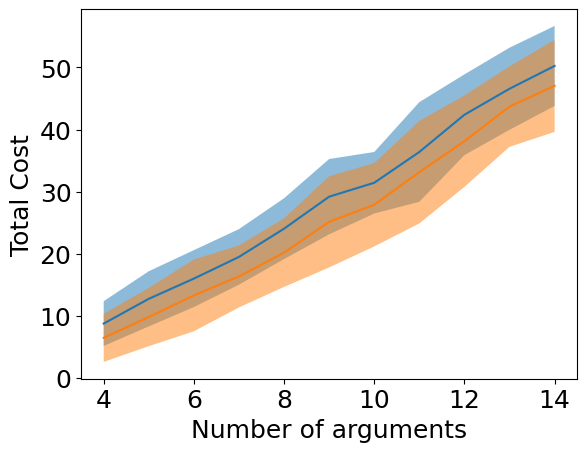

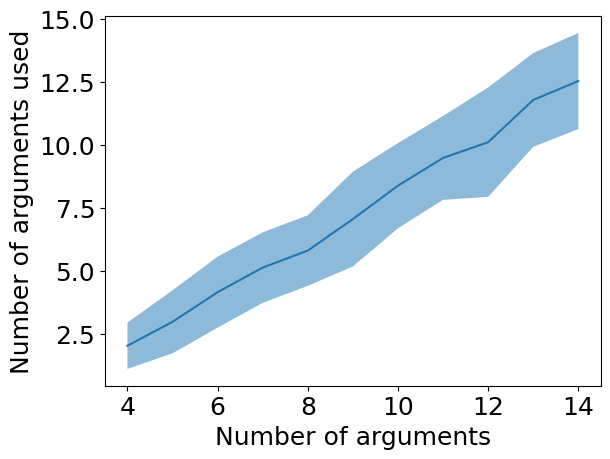

In [10]:
#HCAT SEMANTICS
#plot the results with the mean and standard deviation of each cost
#compute the standard deviation of each cost

#show the standard deviation as a shaded region in the plot around the mean
plt.plot(df["cost1"].groupby(df["numargs"]).mean())
plt.fill_between(list(df["numargs"].unique()),
                 list(df["cost1"].groupby(df["numargs"]).mean()-df["cost1"].groupby(df["numargs"]).std()),
                 list(df["cost1"].groupby(df["numargs"]).mean()+df["cost1"].groupby(df["numargs"]).std()),
                 alpha=0.5)

#plt.plot(df["cost2"].groupby(df["numargs"]).mean())
#plt.fill_between(list(df["numargs"].unique()),
#                 list(df["cost2"].groupby(df["numargs"]).mean()-df["cost2"].groupby(df["numargs"]).std()),
#                 list(df["cost2"].groupby(df["numargs"]).mean()+df["cost2"].groupby(df["numargs"]).std()),
#                 alpha=0.5)


plt.plot(df["cost3"].groupby(df["numargs"]).mean())
plt.fill_between(list(df["numargs"].unique()),
                 list(df["cost3"].groupby(df["numargs"]).mean()-df["cost3"].groupby(df["numargs"]).std()),
                 list(df["cost3"].groupby(df["numargs"]).mean()+df["cost3"].groupby(df["numargs"]).std()),
                 alpha=0.5)

plt.xlabel("Number of arguments")
plt.ylabel("Total Cost")
plt.show()


#work out the mean and standard deviation of the number of arguments used according to numarg3
plt.plot(df["numarg3"].groupby(df["numargs"]).mean())
plt.fill_between(list(df["numargs"].unique()),
                 list(df["numarg3"].groupby(df["numargs"]).mean()-df["numarg3"].groupby(df["numargs"]).std()),
                 list(df["numarg3"].groupby(df["numargs"]).mean()+df["numarg3"].groupby(df["numargs"]).std()),
                 alpha=0.5)
plt.xlabel("Number of arguments")
plt.ylabel("Number of arguments used")
plt.show()


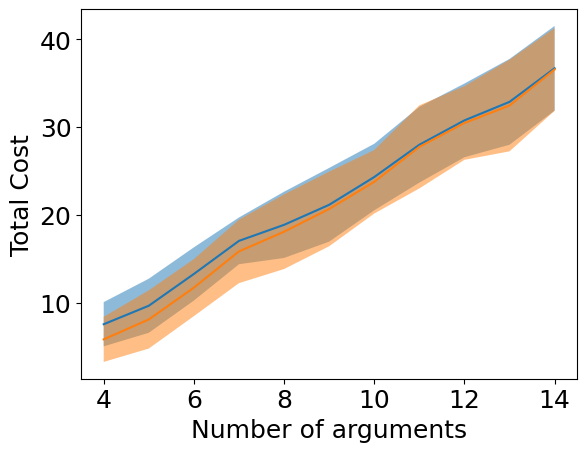

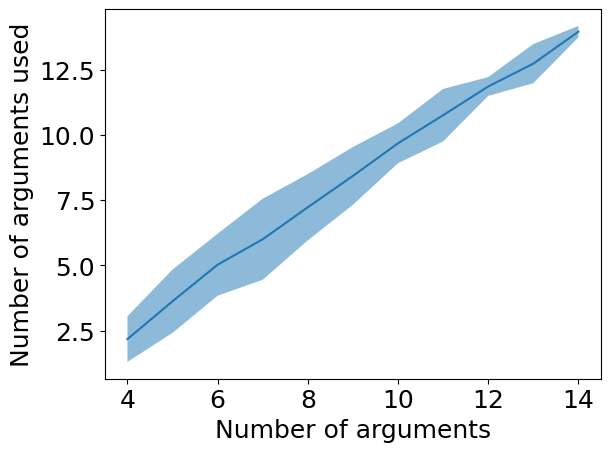

In [13]:
#MBS semantics
#plot the results with the mean and standard deviation of each cost
#compute the standard deviation of each cost

#show the standard deviation as a shaded region in the plot around the mean
plt.plot(df["cost1"].groupby(df["numargs"]).mean())
plt.fill_between(list(df["numargs"].unique()),
                 list(df["cost1"].groupby(df["numargs"]).mean()-df["cost1"].groupby(df["numargs"]).std()),
                 list(df["cost1"].groupby(df["numargs"]).mean()+df["cost1"].groupby(df["numargs"]).std()),
                 alpha=0.5)

#plt.plot(df["cost2"].groupby(df["numargs"]).mean())
#plt.fill_between(list(df["numargs"].unique()),
#                 list(df["cost2"].groupby(df["numargs"]).mean()-df["cost2"].groupby(df["numargs"]).std()),
#                 list(df["cost2"].groupby(df["numargs"]).mean()+df["cost2"].groupby(df["numargs"]).std()),
#                 alpha=0.5)


plt.plot(df["cost3"].groupby(df["numargs"]).mean())
plt.fill_between(list(df["numargs"].unique()),
                 list(df["cost3"].groupby(df["numargs"]).mean()-df["cost3"].groupby(df["numargs"]).std()),
                 list(df["cost3"].groupby(df["numargs"]).mean()+df["cost3"].groupby(df["numargs"]).std()),
                 alpha=0.5)

plt.xlabel("Number of arguments")
plt.ylabel("Total Cost")
plt.show()


#work out the mean and standard deviation of the number of arguments used according to numarg3
plt.plot(df["numarg3"].groupby(df["numargs"]).mean())
plt.fill_between(list(df["numargs"].unique()),
                 list(df["numarg3"].groupby(df["numargs"]).mean()-df["numarg3"].groupby(df["numargs"]).std()),
                 list(df["numarg3"].groupby(df["numargs"]).mean()+df["numarg3"].groupby(df["numargs"]).std()),
                 alpha=0.5)
plt.xlabel("Number of arguments")
plt.ylabel("Number of arguments used")
plt.show()

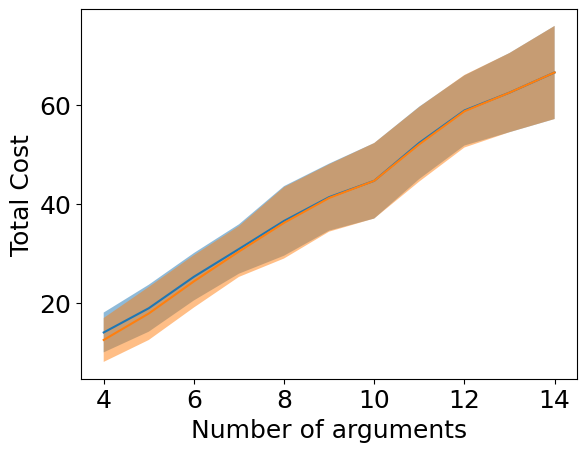

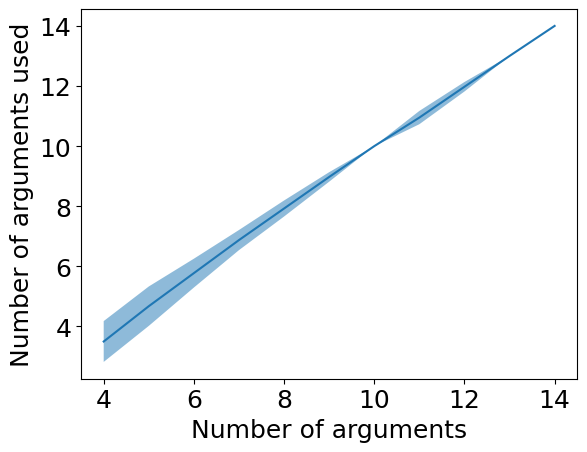

In [16]:
#CARD semantics
#plot the results with the mean and standard deviation of each cost
#compute the standard deviation of each cost

#show the standard deviation as a shaded region in the plot around the mean
plt.plot(df["cost1"].groupby(df["numargs"]).mean())
plt.fill_between(list(df["numargs"].unique()),
                 list(df["cost1"].groupby(df["numargs"]).mean()-df["cost1"].groupby(df["numargs"]).std()),
                 list(df["cost1"].groupby(df["numargs"]).mean()+df["cost1"].groupby(df["numargs"]).std()),
                 alpha=0.5)

#plt.plot(df["cost2"].groupby(df["numargs"]).mean())
#plt.fill_between(list(df["numargs"].unique()),
#                 list(df["cost2"].groupby(df["numargs"]).mean()-df["cost2"].groupby(df["numargs"]).std()),
#                 list(df["cost2"].groupby(df["numargs"]).mean()+df["cost2"].groupby(df["numargs"]).std()),
#                 alpha=0.5)


plt.plot(df["cost3"].groupby(df["numargs"]).mean())
plt.fill_between(list(df["numargs"].unique()),
                 list(df["cost3"].groupby(df["numargs"]).mean()-df["cost3"].groupby(df["numargs"]).std()),
                 list(df["cost3"].groupby(df["numargs"]).mean()+df["cost3"].groupby(df["numargs"]).std()),
                 alpha=0.5)

plt.xlabel("Number of arguments")
plt.ylabel("Total Cost")
plt.show()


#work out the mean and standard deviation of the number of arguments used according to numarg3
plt.plot(df["numarg3"].groupby(df["numargs"]).mean())
plt.fill_between(list(df["numargs"].unique()),
                 list(df["numarg3"].groupby(df["numargs"]).mean()-df["numarg3"].groupby(df["numargs"]).std()),
                 list(df["numarg3"].groupby(df["numargs"]).mean()+df["numarg3"].groupby(df["numargs"]).std()),
                 alpha=0.5)
plt.xlabel("Number of arguments")
plt.ylabel("Number of arguments used")
plt.show()

In [ ]:
#we are going to try a new heuristic strategy, effectively using dynamic decomposition to split the space and look for the nearest rational CAF.
#we consider the hypercube of the CAF, and then split it into 2^N subspaces, where N is the number of arguments.

def all_rational_corners(caf,corners,semantics):
        allcorners = all_corners(corners)
        rational_corners=[]
        for c in allcorners:
            deg = {}
            for i in range(len(caf.af.nodes)):
                deg[i]=c[i]
            weights = semantics(caf.af,deg)
            if max(weights)>1 or min(weights)<0:
                continue
            else:
                rational_corners.append(c)
        return rational_corners
    
def split_hypercube(corners):
    #split the hypercube into 2^N subcubes. We assume that corners is a pair containing the min and max values for two corners of the hypercube.
    #For example, given (0,0),(1,1) as input we want output ((0,0),(0.5,0.5)),((0.5,0.5),(1,1)),((0,0.5),(0.5,1)),((0.5,0),(1,0.5))
    new_corners = []

    middle = []
    for i in range(len(corners[0])):
        middle.append((corners[0][i]+corners[1][i])/2)

    ps = powerset(range(len(corners[0])))
    for p in ps:
        c1 = []
        c2 = []
        for i in range(len(corners[0])):
            if i in p:
                c1.append(corners[0][i])
                c2.append(middle[i])
            else:
                c1.append(middle[i])
                c2.append(corners[1][i])
        new_corners.append((tuple(c1),tuple(c2)))
    return new_corners


def all_corners(corners):
    #given a set of corners, return all the corners of the hypercube
    new_corners = []
    ps = powerset(range(len(corners[0])))
    for p in ps:
        c = []
        for i in range(len(corners[0])):
            if i in p:
                c.append(corners[0][i])
            else:
                c.append(corners[1][i])
        new_corners.append(tuple(c))
    return new_corners

def corner_distance(c1,c2):
    #compute the distance between two corners
    d=0
    for i in range(len(c1)):
        d+=(c1[i]-c2[i])**2
    return d

def make_rational_hypercube(caf,semantics,epsilon):
    #our initial cube is the min/max of the CAF intervals
    start_point = list(map(lambda x: x[0],caf.intervals.values()))
    corner0 = [0]*len(caf.af.nodes)
    corner1 = start_point

    possible_cubes = [(tuple(corner0),tuple(corner1))]

    finished = False

    while not finished:
        print(len(possible_cubes))
        collected_cubes = []
        for p in possible_cubes:
            sub_cubes = split_hypercube(p)
            for s in sub_cubes:
                nrh = all_rational_corners(caf,s,semantics)
                if len(nrh)>0 and len(nrh)<len(caf.af.nodes):
                    collected_cubes.append(s)
        
        #remove those cubes from collected_cubes whose corners are all further than any other cube from start_poin

        best_distance = 999999999

        fd_cache = {}

        for p in collected_cubes:
            furthest_distance = 0
            for c in all_corners(p):
                d = corner_distance(c,start_point)
                if d>furthest_distance:
                    furthest_distance=d
            if furthest_distance<best_distance:
                best_distance=furthest_distance
            #cache the furthest distance for the cube
            fd_cache[p]=furthest_distance
        
        possible_cubes = [p for p in collected_cubes if fd_cache[p]<=best_distance]

        #check if we are finished
        if len(possible_cubes)==0 or corner_distance(possible_cubes[0][0],possible_cubes[0][1])<epsilon:
            finished=True

    #for all remaining possible cubes find the one whose corner point is rational and closest to the start_point
    best_distance = 999999999
    best_corner = None
    for p in possible_cubes:
        for c in all_corners(p):
            d={}
            for i in range(len(caf.af.nodes)):
                d[i]=c[i]
            w = semantics(caf.af,d)
            if max(w)>1 or min(w)<0:
                continue
            else:
                d = corner_distance(c,start_point)
                if d<best_distance:
                    best_distance=d
                    best_corner=c
    
    return best_corner

        

            





    

In [ ]:
caf = make_random_graph(10)
for i in range(10):
    caf.intervals[i]=(0.8+random.random()*0.2,1)

start_point = list(map(lambda x: x[0],caf.intervals.values()))

end = make_rational_hypercube(caf,SEMANTICS,0.01)
print(corner_distance(end,start_point))

In [34]:
nc = make_rational2(caf,0.01).intervals
end = list(map(lambda x: x[0],nc.values()))

print(corner_distance(end,start_point))

1.4832727375624615
